# Part 1

The housing estate is laid out as shown in Figure 1, each house is fed by a single-phase connection. You may assume that the average power profile of the homes follows the Elexon Class 1 curves1, but all scaled to ensure that the a winter peak is 1.25kW.

At the time of the original design, it is known that an ADMD of 2kW was used. The transformer at the substation is rated at 33kV/415 V, 250 kVA, Z=14% pu. The same cable size is used throughout.

The **phase voltage** is the voltage between a phase sub cable (that goes into a house) and ground.

The **line voltage** is the voltage difference between each phase. It's difference between each of the three lines in one cable. Since the phases are at a certain geometric offset, we multiply this by sqrt(3)

Transformer is creating a three-phase output.

This is why we have: 
$$
V_{phase} = \frac{V_{line}}{\sqrt 3}
$$

$$
V_{phase} = \frac{415 V}{\sqrt 3} = 239.6003617137
$$
We round this to 240 V

For a UK DNO, the voltage drop from a transformer to the end of a line should be max 7%

For minimum voltage at the end of the line:

$$
V_{phase} = 240 V * 0.93
$$

$$
V_{phase} = 223.2 V
$$

We derive $R_{line}$ with the voltage drop from the top to the bottom:

$$
V_{phase, transformer} - I*R_{Line} = V_{phase, end of line}
$$
$$
240V - I*R_{Line} = 223 V
$$

$$
R_{line} = \frac{17}{I_{current at the top of the transformer}}
$$

Power going into each home should be around **56 kW** due for low voltage, residential, and radial design standards. We then use this to derive the current of the cable.

$$
P = IV
$$

$$
I = \frac{P}{V}
$$

$$
I = \frac{56 kW}{240 V}
$$

$$
I = 233.3333333333 A
$$

Now, let's consider the power going into each house.

We want the power into each house to be $P_{house} = 2kW$
We also want the voltage to be $V_{house} = 240$
With this, we calculate the home's current:

$$
I_{home} = \frac{P_{home}}{V_{home}}
$$

$$
I_{home} = \frac{2000 W}{240 V}
$$

$$
I_{home} = 8.333 A
$$

How do we calculate the overall current?

We want one phase to provide power for three houses at a time.

In one side of a road, we have 24 houses. Therefore, we need 8 buses to supply 24 houses.

Each bus will provide current for three houses. So, each bus will provide $3*I_{home}$ of current. For one road, we have 8 buses that provide a total of $24*I_{home}$

But each bus provides three phases, so to calculate the current in each phase cable, we divide that by three

$$
I_{phase} = \frac{24 * I_{home}}{3 \text{ phases}}
$$

$$
I_{phase} = 8 * I_{home}
$$

$$
I_{phase} = 8 * 8.333 A
$$

$$
I_{phase} = 66.7 A
$$

With this max amperage, we see that we can use the BS 5467 MAINS CABLE XLPE with the following conditions:
- 1 THREE OR1 FOUR CORE CABLE THREE-PHASE AC : 75 A
- 16 MM^2

(https://www.clevelandcable.com/media/pdfs/BS5467-XLPE-MDPE-fixed-wiring-mains-cable.pdf)

$$
R = \frac{\rho L}{A}
$$

$$
R = \frac{\rho L}{0.248 m^2}
$$


In [1]:
import pandapower as pp
import pandapower.networks as nw
import pandapower.plotting as plot
%matplotlib inline

# create an empty network
net = pp.create_empty_network()


#create bus from high voltage 
high_voltage_volts = 33e3
high_voltage_kv = 33

low_voltage_volts = 415
low_voltage_kv = 0.415
high_voltage_bus = pp.create_bus(net, vn_kv=high_voltage_kv, name="High Voltage ")
low_voltage_bus = pp.create_bus(net, vn_kv=low_voltage_kv, name="Low Voltage")

real_impedance = 0.1 # assumption given from professor
total_impedance = 0.14
iron_losses = 0.00125 # 0.5 percent of the rating of the transformer. 0.25 M VA *0.005 here
open_loop_losses = 0.5 # to verify, we used previously apparently

# The transformer at the substation is rated at 
# 33kV/415 V, 250 kVA, Z=14% pu.
# 33kV/0.415 kV, 0.250 MVA, Z=14% pu.


# We chose a transformer here:
# https://pandapower.readthedocs.io/en/v2.13.1/std_types/basic.html#transformers
# transformer = pp.create_transformer(
#   net,
#   hv_bus=high_voltage_bus,
#   lv_bus=low_voltage_bus,
#   std_type="0.25 MVA 20/0.4 kV",
#   name="Main Transformer")

transformer = pp.create_transformer_from_parameters(
  net,
  hv_bus=high_voltage_bus,
  lv_bus=low_voltage_bus,
  sn_mva=0.25,
  vn_hv_kv=high_voltage_kv,
  vn_lv_kv=low_voltage_kv,
  vkr_percent=real_impedance,
  vk_percent=total_impedance,
  pfe_kw=iron_losses,
  i0_percent=open_loop_losses,
  shift_degree=0,
  tap_side="hv",
  tap_pos=-2, # lower here, means higher voltage on the other side due to the ratios
  tap_neutral=0,
  tap_max=-5, # 5 percent up and down
  tap_min=5,
  tap_step_percent=1, # one step at a time (given in the question)
  tap_step_degree=0, # we're not doing any phase shifting
  tap_phase_shifter=False,
  name="Main Transformer")


In [2]:
# create the slack bus
slack_voltage_per_unit = 1.00 # we reduced this to 0 since the tap changer is controlling the voltage now
pp.create_ext_grid(net, bus=high_voltage_bus, vm_pu=slack_voltage_per_unit, name="Grid Connection with Slack Bus")

0

Now, let's create the buses for the loads

In [3]:
num_buses_per_line = 8
num_lines = 4

"""
- - - - - - - -
"""
lines = []
for line in range(num_lines):
  buses_for_line = []
  for i in range(num_buses_per_line):
    buses_for_line.append(pp.create_bus(net, vn_kv=low_voltage_kv, name=f"Bus {i+1}"))
  lines.append(buses_for_line[:])
lines

[[2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17],
 [18, 19, 20, 21, 22, 23, 24, 25],
 [26, 27, 28, 29, 30, 31, 32, 33]]

In [4]:
# Create a bus for each group of three houses
power_per_house_mw = 0.002 # 2 kW
real_power_load_per_three_houses = 3 * power_per_house_mw
power_factor = 0.95

hypotenuse = real_power_load_per_three_houses / power_factor

# rp^2 + im^2 = h^2
# im = sqrt(h^2 - rp^2)

reactive_power_per_three_houses = (hypotenuse**2 - real_power_load_per_three_houses**2)**0.5
for line in range(num_lines):
  for i in range(num_buses_per_line):
    pp.create_load(net, bus=lines[line][i-1], p_mw=real_power_load_per_three_houses, q_mvar=reactive_power_per_three_houses, name=f"Load for bus {i+1}")

$$
C = \frac{\Epsilon_{r}}{18 * ln(\frac{D_{out}}{D_{in}})} \mu F / km
$$
Find D_{in} from mm^2 of 35. We add 2 mm of insulation on each side
$$
C = \frac{\Epsilon_{r}}{18 * ln(\frac{4 mm}{D_{in}})} \mu F / km
$$

In [5]:
# Now create lines between the buses

width_of_home_km = 0.012 # 12 meters 
line_resistance_per_km = 1.15 # ohms per km
line_reactance_per_km = 0.135 # 0.135 ohms per km
line_capacitance_per_km = 0.296e3 # nano Farads per km
max_thermal_current_kA = 0.115 # this is the rating of our cable in kA

for line in range(num_lines):
  for i in range(num_buses_per_line):
    if i == 0:
      pp.create_line_from_parameters(
        net,
        from_bus=low_voltage_bus,
        to_bus=lines[line][i],
        length_km=width_of_home_km*9,
        r_ohm_per_km=line_resistance_per_km,
        x_ohm_per_km=line_reactance_per_km,
        c_nf_per_km=line_capacitance_per_km,
        max_i_ka=max_thermal_current_kA,
        name=f"Line from High Voltage to Bus {i+1}")
    else:
      pp.create_line_from_parameters(
        net,
        from_bus=lines[line][i-1],
        to_bus=lines[line][i],
        length_km=width_of_home_km*3,
        r_ohm_per_km=line_resistance_per_km,
        x_ohm_per_km=line_reactance_per_km,
        c_nf_per_km=line_capacitance_per_km,
        max_i_ka=max_thermal_current_kA,
        name=f"Line from Bus {i} to Bus {i+1}")
net.line

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service
0,Line from High Voltage to Bus 1,None,1,2,0.108,1.15,0.135,296.0,0.0,0.115,1.0,1,None,True
1,Line from Bus 1 to Bus 2,None,2,3,0.036,1.15,0.135,296.0,0.0,0.115,1.0,1,None,True
2,Line from Bus 2 to Bus 3,None,3,4,0.036,1.15,0.135,296.0,0.0,0.115,1.0,1,None,True
3,Line from Bus 3 to Bus 4,None,4,5,0.036,1.15,0.135,296.0,0.0,0.115,1.0,1,None,True
4,Line from Bus 4 to Bus 5,None,5,6,0.036,1.15,0.135,296.0,0.0,0.115,1.0,1,None,True
5,Line from Bus 5 to Bus 6,None,6,7,0.036,1.15,0.135,296.0,0.0,0.115,1.0,1,None,True
6,Line from Bus 6 to Bus 7,None,7,8,0.036,1.15,0.135,296.0,0.0,0.115,1.0,1,None,True
7,Line from Bus 7 to Bus 8,None,8,9,0.036,1.15,0.135,296.0,0.0,0.115,1.0,1,None,True
8,Line from High Voltage to Bus 1,None,1,10,0.108,1.15,0.135,296.0,0.0,0.115,1.0,1,None,True
9,Line from Bus 1 to Bus 2,None,10,11,0.036,1.15,0.135,296.0,0.0,0.115,1.0,1,None,True


In [6]:
net.bus

,name,vn_kv,type,zone,in_service
0,High Voltage,33.000,b,None,True
1,Low Voltage,0.415,b,None,True
2,Bus 1,0.415,b,None,True
3,Bus 2,0.415,b,None,True
4,Bus 3,0.415,b,None,True
5,Bus 4,0.415,b,None,True
6,Bus 5,0.415,b,None,True
7,Bus 6,0.415,b,None,True
8,Bus 7,0.415,b,None,True
9,Bus 8,0.415,b,None,True


In [7]:
pp.runpp(net, numba=False)

In [8]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-0.206283,-0.066218
1,1.019348,-0.030086,0.000000,0.000000
2,0.981577,0.388551,0.006000,0.001972
3,0.970525,0.516803,0.006000,0.001972
4,0.961020,0.629086,0.006000,0.001972
5,0.953077,0.724368,0.006000,0.001972
6,0.946708,0.801748,0.006000,0.001972
7,0.941922,0.860471,0.006000,0.001972
8,0.938728,0.899953,0.006000,0.001972
9,0.937129,0.919798,0.006000,0.001972


In [9]:
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,0.051526,0.016185,-0.049501,-0.015949,0.002024,2.359161e-04,0.073710,0.073711,0.073711,1.019348,-0.030086,0.981577,0.388551,64.096147
1,0.043501,0.013977,-0.042980,-0.013917,0.000521,6.059601e-05,0.064759,0.064760,0.064760,0.981577,0.388551,0.970525,0.516803,56.312621
2,0.036980,0.011945,-0.036595,-0.011900,0.000385,4.470680e-05,0.055706,0.055706,0.055706,0.970525,0.516803,0.961020,0.629086,48.440387
3,0.030595,0.009928,-0.030326,-0.009897,0.000269,3.108389e-05,0.046564,0.046564,0.046564,0.961020,0.629086,0.953077,0.724368,40.490247
4,0.024326,0.007925,-0.024152,-0.007905,0.000173,1.981351e-05,0.037345,0.037345,0.037345,0.953077,0.724368,0.946708,0.801748,32.473821
5,0.018152,0.005933,-0.018055,-0.005922,0.000098,1.096877e-05,0.028064,0.028064,0.028064,0.946708,0.801748,0.941922,0.860471,24.403448
6,0.012055,0.003950,-0.012011,-0.003945,0.000044,4.608200e-06,0.018736,0.018736,0.018736,0.941922,0.860471,0.938728,0.899953,16.292065
7,0.006011,0.001973,-0.006000,-0.001972,0.000011,7.744959e-07,0.009376,0.009376,0.009376,0.938728,0.899953,0.937129,0.919798,8.153077
8,0.051526,0.016185,-0.049501,-0.015949,0.002024,2.359161e-04,0.073710,0.073711,0.073711,1.019348,-0.030086,0.981577,0.388551,64.096147
9,0.043501,0.013977,-0.042980,-0.013917,0.000521,6.059601e-05,0.064759,0.064760,0.064760,0.981577,0.388551,0.970525,0.516803,56.312621


No or insufficient geodata available --> Creating artificial coordinates. This may take some time


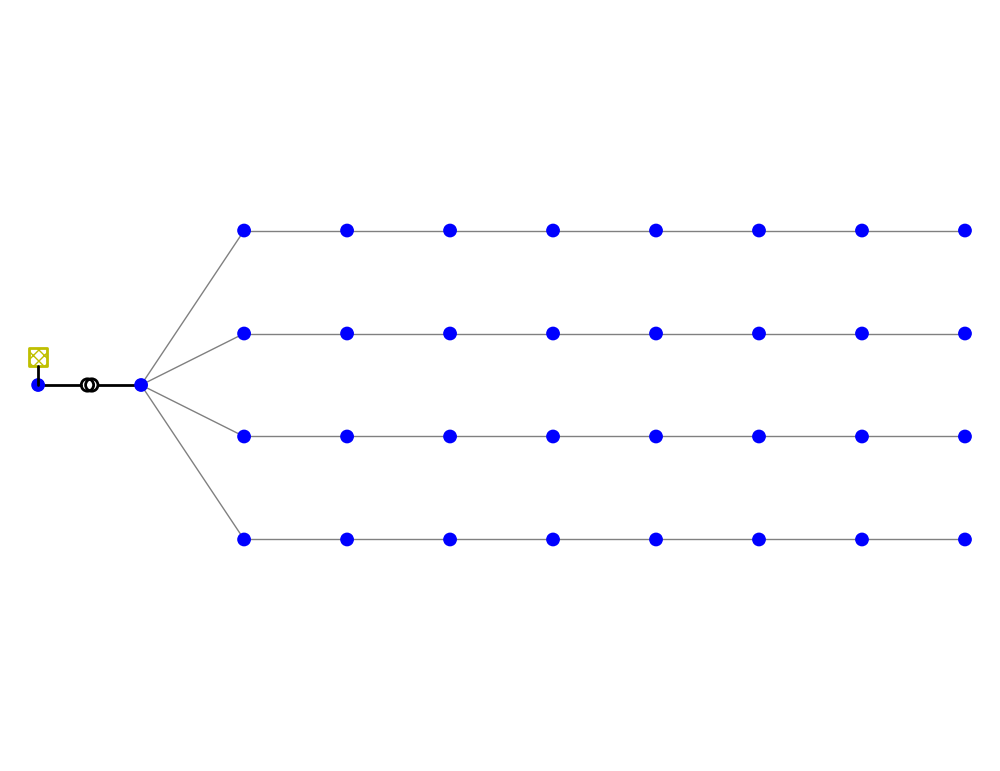

<Axes: >

In [10]:
pp.plotting.simple_plot(net)

In [11]:
net.res_trafo

,p_hv_mw,q_hv_mvar,p_lv_mw,q_lv_mvar,pl_mw,ql_mvar,i_hv_ka,i_lv_ka,vm_hv_pu,va_hv_degree,vm_lv_pu,va_lv_degree,loading_percent
0,0.206283,0.066218,-0.206102,-0.064741,0.000181,0.001477,0.00379,0.294839,1.0,0.0,1.019348,-0.030086,86.660375


In [12]:
cmap_list=[(0, "green"), (50, "yellow"), (100, "red")]
cmap, norm = plot.cmap_continuous(cmap_list)

use_bus_geodata is automatically set to True, since net.line_geodata is empty.


<Axes: >

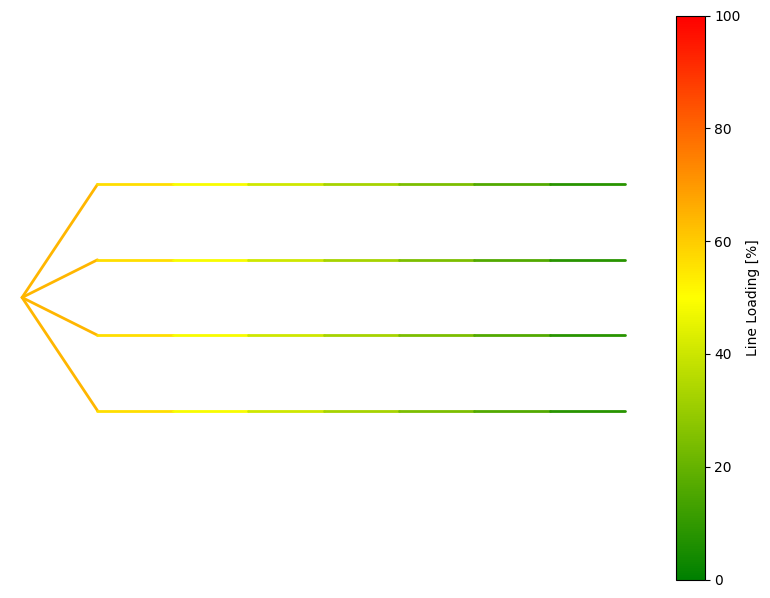

In [13]:
lc = plot.create_line_collection(net, net.line.index, zorder=1, cmap=cmap, norm=norm, linewidths=2)
plot.draw_collections([lc], figsize=(8,6))

<Axes: >

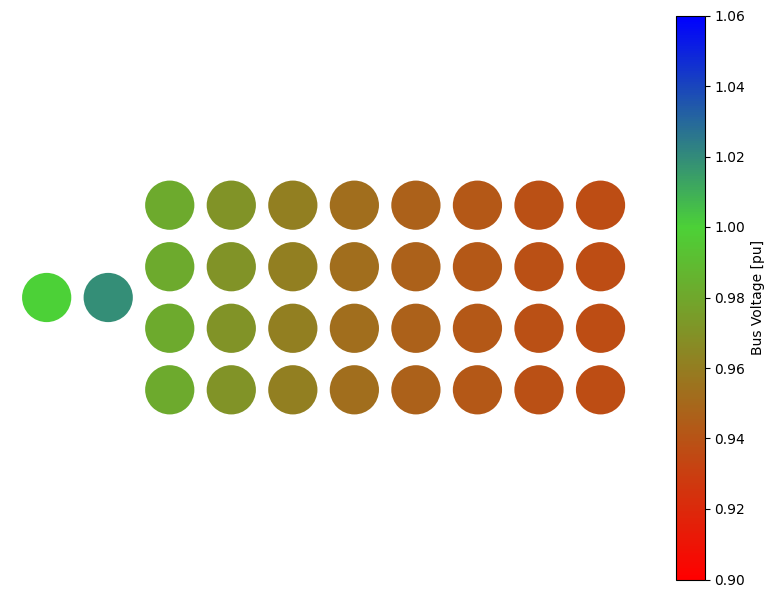

In [31]:
ideal_color = "#4cd137"
too_high_color = "blue"
too_low_color = "red"
cmap_list=[(0.9, too_low_color), (1.0, ideal_color), (1.06, too_high_color)] #+6 and -10 percent for voltage regulations
cmap, norm = plot.cmap_continuous(cmap_list)
bc = plot.create_bus_collection(net, net.bus.index, size=0.4, zorder=2, cmap=cmap, norm=norm)
plot.draw_collections([bc], figsize=(8,6))